In [55]:
import os
import datetime

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
pd.options.display.max_columns = 150

In [337]:
# functions used throughout notebook
def load_data(filename, prefix):
    """Combine all three years of data for a file. Places prefix for each column"""
    years = ['s2014','s2015','s2016']
    mid_path = '/data/'
     
    for year in years:        
        path = year + mid_path + filename + '.csv'
        df = pd.read_csv(path,parse_dates = ['Date'], infer_datetime_format=True, index_col = 0, encoding='latin1')
        if year == 's2014':
            df_m = df
        else:
            df_m = df_m.append(df)
    
    df_m.columns = prefix + "__" + np.array(df_m.columns)
    df_m.reset_index(drop = True, inplace = True)
    
    # drop all % signs from dataframe
    for col in [col for col in df_m.columns if col.endswith('%')]:
        df_m[col] = df_m[col].str.replace("%","").astype(float)
    for col in [col for col in df_m.columns if col.endswith('HR/FB')]:
        df_m[col] = df_m[col].str.replace("%","").astype(float)
    
    # drop fake index col
    cols = [col for col in df_m.columns if not col.endswith("#")]
    df_m = df_m[cols]
    
    cols = [prefix + "__" + x for x in ['Date','Team','Name']]
    cols = [col for col in df_m.columns if col in cols]
    df_m.drop_duplicates(subset = cols, inplace = True)
    return df_m

def target_percent(df):
    """Calculate percent of set that results in ten selections per day
    
    Args:
        df: Full set dataframe
        
    Returns:
        Threshold value to be passed to np.percentile
    """
    game_count = df.date.unique().shape[0]
    at_bats = df.shape[0]
    pct = 10 / (at_bats / game_count)
    
    return 100 - round(pct * 100, 2)

def load_analysis_set(version):
    """Load analysis data set. Processes if necessary.
    Args:
        version: int. checkpointed version of data
        
    Returns:
        df: Analysis dataframe
    """ 
    file = 'data/analysis_' + str(version) + "_.csv"
    
    df = pd.read_csv(file, parse_dates=['date', 'date_m1'], encoding = 'latin1')
    
    return df

def random_predictions(df):
    """Returns array of random ones and zeros consistent with hit rate"""
    rate = df[df.model_set == 'train'].got_hit.mean()
    dev_size = (df.model_set == 'dev').sum()
    t = [1] * int(dev_size * rate)
    t += ([0] * (dev_size - len(t)))
    t = shuffle(np.array(t))
    return t

def rate_histogram(df, features):
    """Plot precision by percentile for a set of features in facetgrid
    
    Args:
        df: model dataframe. must have features and model_set column
        features: names of columns to plot
    """
    # get percentile groupings of train set for selected features
    df = df[df.model_set == 'train']
    df_long = pd.DataFrame(columns=['percentile', 'feature', 'got_hit'])
    labels = [x for x in range(1,11)]
    for feature in features:
        bins = pd.cut(df[feature], bins=10, labels=labels)
        df_temp = pd.DataFrame({'percentile': bins, 
                                'feature': [feature] * len(bins), 
                                'got_hit': df.got_hit.tolist()})
        df_long = pd.concat([df_long, df_temp])
    
    # get average hit rate
    df_long['got_hit'] = pd.to_numeric(df_long.got_hit)
    df_long['percentile'] = pd.to_numeric(df_long.percentile)
    df_long = df_long.groupby(['feature', 'percentile']).mean().reset_index()
    
    # plot as facet grid
    g = sns.FacetGrid(df_long, col="feature", col_wrap=3)
    g = g.map(plt.plot, "percentile", "got_hit", marker = ".")
    g.set_titles("{col_name}")

not_features = ['date','home','matchup','opp_pitcher','opp_pitcher_lefty',
                'opp_team','own_pitcher','own_pitcher_lefty','team', 'date_m1',
                'team_fg','opp_team_fg','got_hit','name','model_set','fs_id']

# Main Analysis
All data transformations and modeling used in final approach is stored here. Unsuccessful attempts are store in [file]
## Build Base Dataframe

In [126]:
team_key = {
    'Chicago Cubs':'CHC',
    'St. Louis Cardinals':'STL',
    'Colorado Rockies': 'COL',
    'Washington Nationals': 'WSN',
    'Minnesota Twins': 'MIN',
    'San Francisco Giants': 'SFG',
    'Boston Red Sox': 'BOS',
    'Toronto Blue Jays': 'TOR',
    'New York Yankees': 'NYY',
    'Seattle Mariners': 'SEA',
    'Atlanta Braves': 'ATL',
    'Baltimore Orioles': 'BAL',
    'Milwaukee Brewers': 'MIL',
    'Philadelphia Phillies': 'PHI',
    'Arizona Diamondbacks': 'ARI',
    'Chicago White Sox': 'CHW',
    'Cincinnati Reds': 'CIN',
    'San Diego Padres':'SDP',
    'Texas Rangers': 'TEX',
    'Los Angeles Angels': 'LAA',
    'Oakland Athletics':'OAK',
    'Tampa Bay Rays': 'TBR',
    'Miami Marlins': 'MIA',
    'Houston Astros': 'HOU',
    'New York Mets': 'NYM',
    'Pittsburgh Pirates': 'PIT',
    'Detroit Tigers': 'DET',
    'Cleveland Indians': 'CLE',
    'Kansas City Royals': 'KCR',
    'Los Angeles Dodgers': 'LAD',
}

# load all game info
matchups_long = pd.read_csv('matchups_long.csv', parse_dates=['date'])
matchups_long.drop('Unnamed: 0', axis = 1, inplace = True)

# date_m1 is used to match statistics
# must match on the day before the game
matchups_long['date_m1'] = matchups_long.date - datetime.timedelta(days = 1)

# drop all star games and double headers
matchups_long = matchups_long[matchups_long.team != 'National League All-Stars']
matchups_long = matchups_long[matchups_long.team != 'American League All-Stars']
matchups_long['team_fg'] = matchups_long.team.apply(lambda x: team_key[x])
matchups_long['opp_team_fg'] = matchups_long.opp_team.apply(lambda x: team_key[x])
matchups_long.drop_duplicates(subset = ['date', 'team_fg', 'opp_team_fg'], inplace = True)

# merge in result of game's at bats (dependent variable)
temp_df = load_data('hitting/results_master','results')
left_variables = ['results__Date','results__Name','results__Team']
temp_df.drop_duplicates(subset=left_variables, inplace = True)
left_variables = ['results__Date','results__Team']
matchups_long = pd.merge(temp_df, matchups_long,
               how = 'left',
               left_on = left_variables,
               right_on = ['date','team_fg'])
matchups_long['got_hit'] = matchups_long.results__AVG > 0
cols = [x for x in matchups_long.columns if not x.startswith('results__')] + ['results__Name']
matchups_long = matchups_long[cols]
matchups_long.rename(columns = {'results__Name': 'name'}, inplace = True)
matchups_long.dropna(inplace = True)

# shuffle and split out model sets
matchups_long = shuffle(matchups_long)
size = len(matchups_long)
model_set = ['train'] * int(size *.5)
model_set += ['dev'] * int(size *.4)
model_set += ['test'] * (size - len(model_set))
matchups_long['model_set'] = model_set
matchups_long['fs_id'] = list(range(0,size))

matchups_long.to_csv('data/analysis_1_.csv', index = False)

## Previous Hit Consistency
Percent that a batter gets at least one hit in game. 

In [127]:
df = load_analysis_set(1)

In [128]:
# load dataset
df_hits = load_data('hitting/results_master','results')
right = ['results__Date','results__Name','results__Team']
df_hits.drop_duplicates(subset = right, inplace = True)
df_hits = df_hits[df_hits.results__G == 1]
df_hits['hit'] = df_hits.results__H > 0
df_hits.sort_values('results__Date', inplace = True)

# calculate cumulative average of getting a hit
gb = ['results__Season', 'results__Team','results__Name']
cols = ['results__G', 'hit']
df_gb = df_hits[gb + cols].groupby(gb).cumsum()
cols = ['hitbin_g_cum', 'hitbin_hit_cum']
df_gb.columns = cols
df_hits = pd.concat([df_hits, pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()], axis = 1)
df_hits['hitbin_avg_cum'] = df_hits.hitbin_hit_cum / df_hits.hitbin_g_cum
df_hits.drop('hitbin_hit_cum', axis = 1, inplace = True)

def drop_small_sample(row):
    """Fill avg with games < 10 with nan"""
    try:
        if row.hitbin_g_cum < 10:
            return np.nan
        else:
            return row.hitbin_avg_cum
    except:
        return np.nan
df_hits['hitbin_avg_cum'] = df_hits.apply(drop_small_sample, axis = 1)

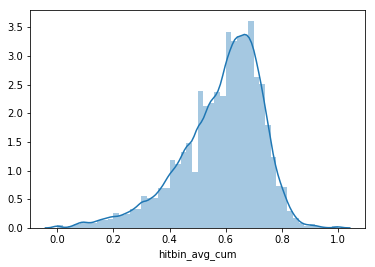

In [129]:
sns.distplot(df_hits.hitbin_avg_cum.dropna())

In [130]:
# calculate rolling averages for hit binary statistic
def concat_window(df_hits, window):
    """Calculates average hit binary for specified window length
    
    Args:
        df_hits: dataframe to calculate
        window: int. Number of games to go back
    
    Returns:
        df_hits with rolling average concatenated as last col
    """
    # calculate rolling average
    gb = ['results__Season', 'results__Team','results__Name']
    cols = ['hit']
    df_gb = df_hits[gb + cols].groupby(gb).rolling(window).mean()
    df_gb = df_gb.drop(gb, axis = 1).reset_index().set_index('level_3').drop(gb, axis = 1)
    cols = ['hitbin_avg_p' + str(window)]
    df_gb.columns = cols
    
    # shift rolling average and concatenate
    df_gb = pd.concat([df_hits, df_gb], axis = 1)[gb + cols].groupby(gb).shift()
    df_gb = pd.concat([df_hits, df_gb], axis = 1)
    return df_gb

df_hits = concat_window(df_hits, 7)
df_hits = concat_window(df_hits, 21)

# merge with main df
columns = df_hits.columns[-4:].tolist()
columns += ['results__Date', 'results__Team','results__Name']
df_hits = df_hits[columns]
df_hits.rename(columns = {'results__Date':'date', 
                          'results__Team':'team_fg',
                          'results__Name':'name'}, 
               inplace = True)
df = pd.merge(df, df_hits, how = 'left', on = ['name', 'date', 'team_fg'])

# drop batters with less than 10 games
# drops about 16% of rows
df.dropna(subset = ['hitbin_avg_cum'], inplace = True)
df.hitbin_avg_p21.fillna(df.hitbin_avg_p7, inplace = True)

In [213]:
# baseline
t = random_predictions(df)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=t, digits = 3))

             precision    recall  f1-score   support

          0      0.416     0.496     0.452     21438
          1      0.577     0.497     0.534     29710

avg / total      0.510     0.496     0.500     51148



In [183]:
features = [x for x in df.columns if x not in not_features]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=75, max_features=None)
m = df.model_set == 'train'
rfc.fit(df.loc[m,features], df[m]['got_hit'])
m = df.model_set == 'dev'
dev_probs = rfc.predict_proba(df.loc[m,features])[:,1]

In [212]:
# random forest. 7% improvement over baseline
thresh = np.percentile(dev_probs, 50)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.482     0.575     0.525     21450
       True      0.644     0.554     0.596     29698

avg / total      0.576     0.563     0.566     51148



In [231]:
df.to_csv('data/analysis_2_.csv', index = False)

## Pitching: Batted Balls

In [363]:
df = load_analysis_set(2)
f_set = 'opp_pitcher_battedballs_season'
temp_df = load_data('pitching/past_3games_batted_balls_master',f_set)
col_match ={'opp_pitcher_battedballs_season__Name': 'opp_pitcher', 
            'opp_pitcher_battedballs_season__Date': 'date_m1', 
            'opp_pitcher_battedballs_season__Team': 'opp_team_fg'}
temp_df.rename(columns=col_match, 
               inplace = True)
df = pd.merge(df, temp_df, how = 'left', on = list(col_match.values()))
df.drop('opp_pitcher_battedballs_season__Season', axis = 1, inplace = True)

In [365]:
df.fillna(-1, inplace = True)
#df.dropna(inplace = True)

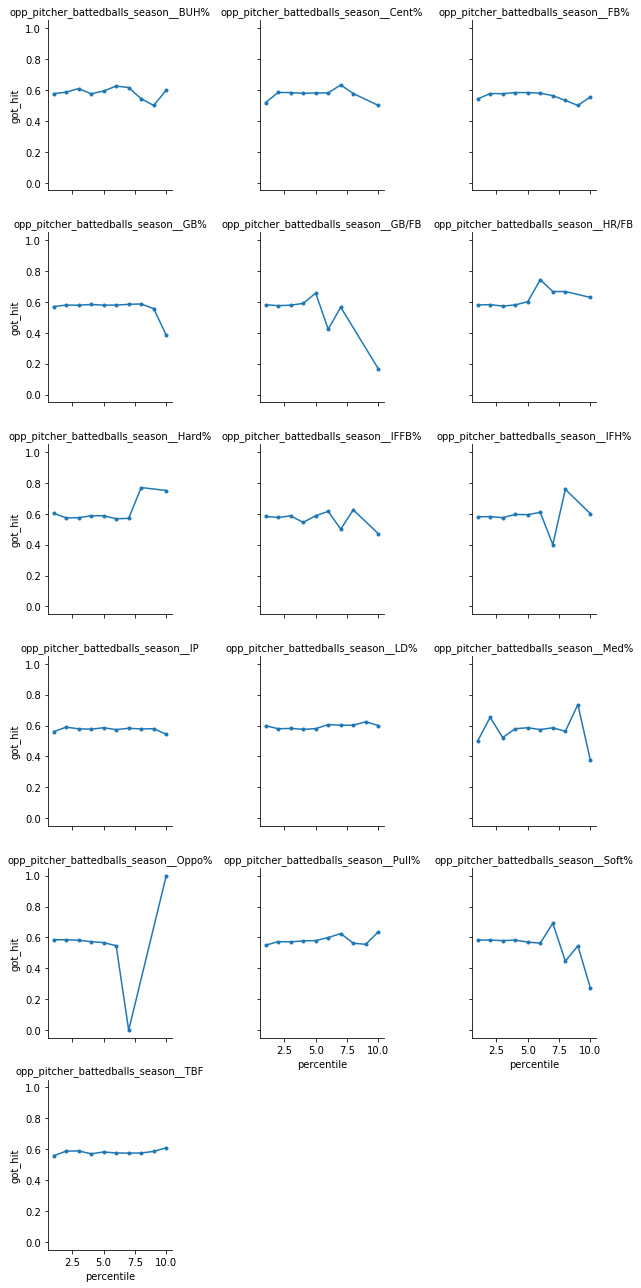

In [364]:
features = [x for x in df.columns if x.startswith(f_set)]
rate_histogram(df, features)

In [366]:
#features = [x for x in df.columns if x not in not_features]
features = [x for x in df.columns if x.startswith(f_set)]
rfc = RandomForestClassifier(n_estimators=100, min_samples_split=75, max_features=None)
m = df.model_set == 'train'
rfc.fit(df.loc[m,features], df[m]['got_hit'])
m = df.model_set == 'dev'
dev_probs = rfc.predict_proba(df.loc[m,features])[:,1]

In [367]:
thresh = np.percentile(dev_probs, 50)
print(metrics.classification_report(y_pred=(dev_probs >= thresh), y_true=df[m]['got_hit'], digits = 3))

             precision    recall  f1-score   support

      False      0.444     0.516     0.477     21450
       True      0.604     0.533     0.566     29698

avg / total      0.537     0.526     0.529     51148



In [350]:
target_percent(df)

95.66

In [358]:
list(zip(features, rfc.feature_importances_))

[('hitbin_g_cum', 0.076313314574435381),
 ('hitbin_avg_cum', 0.23201789142120291),
 ('hitbin_avg_p7', 0.02054251533061251),
 ('hitbin_avg_p21', 0.029622471599442712),
 ('opp_pitcher_battedballs_season__IP', 0.033427952632198075),
 ('opp_pitcher_battedballs_season__TBF', 0.038828228350659952),
 ('opp_pitcher_battedballs_season__K/9', 0.036564928592294918),
 ('opp_pitcher_battedballs_season__BB/9', 0.023823206352072974),
 ('opp_pitcher_battedballs_season__K/BB', 0.027994957581633576),
 ('opp_pitcher_battedballs_season__HR/9', 0.024875696762826721),
 ('opp_pitcher_battedballs_season__K%', 0.042957599706483614),
 ('opp_pitcher_battedballs_season__BB%', 0.038205634791520338),
 ('opp_pitcher_battedballs_season__K-BB%', 0.045561611047799273),
 ('opp_pitcher_battedballs_season__AVG', 0.045804644168503467),
 ('opp_pitcher_battedballs_season__WHIP', 0.04170551459023656),
 ('opp_pitcher_battedballs_season__BABIP', 0.051334429266260147),
 ('opp_pitcher_battedballs_season__LOB%', 0.0650503279839499

In [329]:
temp_df[temp_df.opp_pitcher_battedballs_season__Name == 'Max Scherzer']

,opp_pitcher_battedballs_season__Season,opp_pitcher_battedballs_season__Name,opp_pitcher_battedballs_season__Team,opp_pitcher_battedballs_season__IP,opp_pitcher_battedballs_season__TBF,opp_pitcher_battedballs_season__GB/FB,opp_pitcher_battedballs_season__LD%,opp_pitcher_battedballs_season__GB%,opp_pitcher_battedballs_season__FB%,opp_pitcher_battedballs_season__IFFB%,opp_pitcher_battedballs_season__HR/FB,opp_pitcher_battedballs_season__IFH%,opp_pitcher_battedballs_season__BUH%,opp_pitcher_battedballs_season__Pull%,opp_pitcher_battedballs_season__Cent%,opp_pitcher_battedballs_season__Oppo%,opp_pitcher_battedballs_season__Soft%,opp_pitcher_battedballs_season__Med%,opp_pitcher_battedballs_season__Hard%,opp_pitcher_battedballs_season__Date
364,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-02
634,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-03
935,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-04
1276,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-05
1633,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-06
1996,2014.0,Max Scherzer,DET,8.0,27.0,0.9,31.6,31.6,36.8,0.0,0.0,0.0,0.0,31.6,31.6,36.8,10.5,68.4,21.1,2014-04-07
2362,2014.0,Max Scherzer,DET,15.0,55.0,1.3,28.9,39.5,31.6,0.0,8.3,13.3,0.0,34.2,42.1,23.7,15.8,50.0,34.2,2014-04-08
2732,2014.0,Max Scherzer,DET,15.0,55.0,1.3,28.9,39.5,31.6,0.0,8.3,13.3,0.0,34.2,42.1,23.7,15.8,50.0,34.2,2014-04-09
3108,2014.0,Max Scherzer,DET,15.0,55.0,1.3,28.9,39.5,31.6,0.0,8.3,13.3,0.0,34.2,42.1,23.7,15.8,50.0,34.2,2014-04-10
3486,2014.0,Max Scherzer,DET,15.0,55.0,1.3,28.9,39.5,31.6,0.0,8.3,13.3,0.0,34.2,42.1,23.7,15.8,50.0,34.2,2014-04-11


In [326]:
df.head()

,date,home,matchup,opp_pitcher,opp_pitcher_lefty,opp_team,own_pitcher,own_pitcher_lefty,team,date_m1,team_fg,opp_team_fg,got_hit,name,model_set,fs_id,hitbin_g_cum,hitbin_avg_cum,hitbin_avg_p7,hitbin_avg_p21
0,2014-09-21,True,Cincinnati Reds @ St. Louis Cardinals,Alfredo Simon,False,Cincinnati Reds,Lance Lynn,False,St. Louis Cardinals,2014-09-20,STL,CIN,True,Daniel Descalso,train,0,90.0,0.277778,0.285714,0.380952
1,2014-04-22,False,Los Angeles Angels @ Washington Nationals,Taylor Jordan,False,Washington Nationals,Tyler Skaggs,True,Los Angeles Angels,2014-04-21,LAA,WSN,False,Raul Ibanez,train,1,17.0,0.529412,0.285714,0.285714
2,2014-06-30,False,Cleveland Indians @ Los Angeles Dodgers,Dan Haren,False,Los Angeles Dodgers,Corey Kluber,False,Cleveland Indians,2014-06-29,CLE,LAD,False,Jason Kipnis,train,3,51.0,0.607843,0.428571,0.714286
3,2014-05-17,True,New York Mets @ Washington Nationals,Bartolo Colon,False,New York Mets,Gio Gonzalez,True,Washington Nationals,2014-05-16,WSN,NYM,False,Tyler Moore,train,4,21.0,0.333333,0.571429,0.333333
4,2015-07-25,True,Oakland Athletics @ San Francisco Giants,Chris Bassitt,False,Oakland Athletics,Madison Bumgarner,True,San Francisco Giants,2015-07-24,SFG,OAK,True,Matt Duffy,train,5,81.0,0.691358,0.857143,0.666667
